## Glacier Detection using Deep Learning
### Training the Neural Network

Accessing our Data in Colab


In [1]:
#import colab package and mount you accounts associated google drive
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Data

Mounted at /content/drive
/content/drive/MyDrive/Data


In [ ]:
%pip install opencv-python matplotlib scikit-image tensorflow keras

Setting up Python environment
######Loading all the necessary libraries and packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from skimage.transform import resize
from skimage.util import random_noise
from skimage import io

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from tensorflow.keras.layers import Lambda, RepeatVector, Reshape
from tensorflow.keras.layers import concatenate, add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from tensorflow.keras import backend as K

We won't use all of these loss metrics at first, but let's go ahead and define them in case we decide to change our loss function later.

In [3]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def dice_coef(y_true, y_pred, smooth=1):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def jaccard_distance_loss(y_true, y_pred, smooth=100):
    """
    Jaccard = (|X & Y|)/ (|X|+ |Y| - |X & Y|)
            = sum(|A*B|)/(sum(|A|)+sum(|B|)-sum(|A*B|))

    The jaccard distance loss is usefull for unbalanced datasets. This has been
    shifted so it converges on 0 and is smoothed to avoid exploding or disapearing
    gradient.

    Ref: https://en.wikipedia.org/wiki/Jaccard_index

    @url: https://gist.github.com/wassname/f1452b748efcbeb4cb9b1d059dce6f96
    @author: wassname
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

Load the data

In [4]:
# Load and convert train and testing data into arrays
data_files = glob.glob('./train_images/*.tif')
data_train = [io.imread(file) for file in data_files]
data_train = np.array(data_train)

data_test_files = glob.glob('./test_images/*.tif')
data_test = [io.imread(file) for file in data_test_files]
data_test = np.array(data_test)

# Load the labels
labels = np.load('./label_train.npy')
labels_test = np.load('./label_test.npy')

We indicate the size of our input images for Tensorflow. We select 512 by 512 since that was how we resized our image collection.

In [5]:
nx = 512
ny = 512

To improve learning of the network, we have to standardize our data through subtracting by the mean and dividing by the standard deviation.

In [6]:
# Standardization across all samples (band specific)
data_scaled = np.zeros(np.shape(data_train))
data_normalized = np.zeros((np.shape(data_train)))
for i in range(np.shape(data_train)[-1]):
    data_mean = np.mean(data_train[:,:,:,i])
    data_std = np.std(data_train[:,:,:,i])
    data_scaled[:,:,:,i] = (data_train[:,:,:,i]-data_mean)/data_std


In [7]:
# Keep it in the positve range?
data_scaled[:,:,:,i] = np.clip((data_scaled[:,:,:,i]+1.0)/2.0,0,1)


In [8]:
# Standardization across all samples (band specific)
data_test_scaled = np.zeros(np.shape(data_test))
data_test_normalized = np.zeros((np.shape(data_test)))
for i in range(np.shape(data_test)[-1]):
    data_test_mean = np.mean(data_test[:,:,:,i])
    data_test_std = np.std(data_test[:,:,:,i])
    data_test_scaled[:,:,:,i] = (data_test[:,:,:,i]-data_test_mean)/data_test_std

We assign our data to variables

In [9]:
x = data_scaled
y = labels[:,:,:] # exclude clutter
x_test = data_test_scaled
y_test = labels_test[:,:,:]

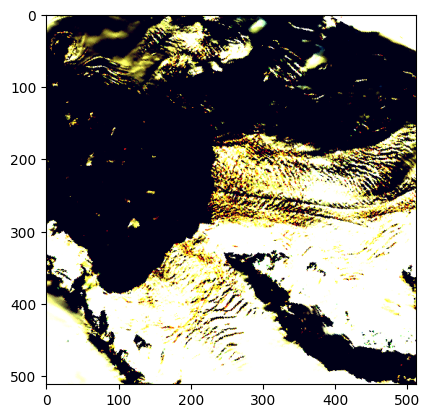

In [10]:
# Plot a random image to see if everything looks alright
plt.imshow(x[8])

Now that we have our data and labels as we want them, we can split our dataset into a portion for training and a portion for validation.

In [11]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=1234)

We can further augment and increase our training data size by introducing data augmentations where we flip the images in various ways, add noise, etc.

In [12]:
# Data augmentation on just the training data
## Image Augmentation
# Vertical Image
Vx = [np.flip(x, axis=1) for x in x_train]
Vy = [np.flip(x, axis=1) for x in y_train]

# Horizontal Image
Hx = [np.flip(x, axis=2) for x in x_train]
Hy = [np.flip(x, axis=2) for x in y_train]

# Horizontal Vertical Image
HVx = [np.flip(x, axis=2) for x in Vx]
HVy = [np.flip(x, axis=2) for x in Vy]

# Appending the augmented image and mask to the main dataset.
x_train = np.append(x_train, Vx, axis=0)
y_train = np.append(y_train, Vy, axis=0)

x_train = np.append(x_train, Hx, axis=0)
y_train = np.append(y_train, Hy, axis=0)

x_train = np.append(x_train, HVx, axis=0)
y_train = np.append(y_train, HVy, axis=0)


Define the neural network

In [13]:
# We need some additional layers already pre-defined in Keras
from tensorflow.keras.layers import (
        BatchNormalization, Conv2D, Conv2DTranspose,
        MaxPooling2D, UpSampling2D, Input,
        concatenate
    )

In [14]:
# define helper functions for building our U-Net blocks
def bn_conv_relu(input, filters, bachnorm_momentum, **conv2d_args):
    x = BatchNormalization(momentum=bachnorm_momentum)(input)
    x = Conv2D(filters, **conv2d_args)(x)
    return x #encoding block

def bn_upconv_relu(input, filters, bachnorm_momentum, **conv2d_trans_args):
    x = BatchNormalization(momentum=bachnorm_momentum)(input)
    x = Conv2DTranspose(filters, **conv2d_trans_args)(x)
    return x #decoding block

#define the U-Net architecture
def satellite_unet(
    input_shape,
    num_classes=1,
    output_activation='sigmoid',
    num_layers=4):

    inputs = Input(input_shape) #initial parameters

    filters = 64
    upconv_filters = 96

    #Define convolution and transposed convolution parameters
    kernel_size = (3,3)
    activation = 'relu'
    strides = (1,1)
    padding = 'same'
    kernel_initializer = 'he_normal'

    conv2d_args = {
        'kernel_size':kernel_size,
        'activation':activation,
        'strides':strides,
        'padding':padding,
        'kernel_initializer':kernel_initializer
        }

    conv2d_trans_args = {
        'kernel_size':kernel_size,
        'activation':activation,
        'strides':(2,2), # Upsampling
        'padding':padding,
        'output_padding':(1,1) # Output padding for transposed convolution
        }

    bachnorm_momentum = 0.01

    # Define max-pooling
    pool_size = (2,2)
    pool_strides = (2,2)
    pool_padding = 'valid'

    maxpool2d_args = {
        'pool_size':pool_size,
        'strides':pool_strides,
        'padding':pool_padding,
        }

    # Build the U-Net architecture
    x = Conv2D(filters, **conv2d_args)(inputs)
    c1 = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
    x = bn_conv_relu(c1, filters, bachnorm_momentum, **conv2d_args)
    x = MaxPooling2D(**maxpool2d_args)(x)

    # Build the encoding and decoding layers
    down_layers = []

    for l in range(num_layers):
        x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
        x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
        down_layers.append(x)
        x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
        x = MaxPooling2D(**maxpool2d_args)(x)

    x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
    x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
    x = bn_upconv_relu(x, filters, bachnorm_momentum, **conv2d_trans_args)

    # Concatenate encoding and decoding layers
    for conv in reversed(down_layers):
        x = concatenate([x, conv])
        x = bn_conv_relu(x, upconv_filters, bachnorm_momentum, **conv2d_args)
        x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
        x = bn_upconv_relu(x, filters, bachnorm_momentum, **conv2d_trans_args)

    x = concatenate([x, c1])
    x = bn_conv_relu(x, upconv_filters, bachnorm_momentum, **conv2d_args)
    x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)

    outputs = Conv2D(num_classes, kernel_size=(1,1), strides=(1,1), activation=output_activation, padding='valid') (x)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

Let's create a model object, compile it, and summarize it. We'll also define our optimizer, Adam, and pick a loss function and tracking metrics.

In [15]:
model = satellite_unet(input_shape=(512, 512, 3), num_classes=2, output_activation='sigmoid', num_layers=3 )
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=["categorical_accuracy", f1])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 512, 512, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 512, 512, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv2d_1 (Conv2D)           (None, 512, 512, 64)         36928     ['batch_normalization[0][0

Callbacks instruct Tensorflow how to behave during training.

In [ ]:
#Let's save our model checkpoints relative to epoch and loss
# checkpoint_filepath = 'weights.{epoch:02d}-{val_loss:.2f}.h5'
# we are able to save the model with different epochs

checkpoint_filepath = 'best_model.h5' # this would loop through and save
#the model weights. it will overwrite the already saved model with the
#latest best weights

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=20, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=30, min_lr=0.00001, verbose=1),
    ModelCheckpoint(checkpoint_filepath, monitor='val_categorical_accuracy',
    mode='max',verbose=1, save_best_only=True, save_weights_only=True)
] # monitors and controls the training process

----- Before Training, Check the system -------

In [ ]:
# Storage
!free -h

               total        used        free      shared  buff/cache   available
Mem:            12Gi       2.9Gi       7.8Gi       4.0Mi       2.0Gi       9.5Gi
Swap:             0B          0B          0B


In [ ]:
#GPU
!nvidia-smi -L

/bin/bash: line 1: nvidia-smi: command not found


Now let's train our model!

In [ ]:
results = model.fit(x_train, y_train, batch_size= 4, epochs=20, callbacks=callbacks,
                   validation_data=(x_val, y_val))

Epoch 1/20
20/20 [==============================] - ETA: 0s - loss: 1.0218 - categorical_accuracy: 0.5120 - f1: 0.4755  
Epoch 1: val_categorical_accuracy improved from -inf to 0.65690, saving model to best_model.h5
20/20 [==============================] - 1448s 71s/step - loss: 1.0218 - categorical_accuracy: 0.5120 - f1: 0.4755 - val_loss: 0.6590 - val_categorical_accuracy: 0.6569 - val_f1: 0.5904 - lr: 0.0010
Epoch 2/20
20/20 [==============================] - ETA: 0s - loss: 0.7559 - categorical_accuracy: 0.5985 - f1: 0.5048  
Epoch 2: val_categorical_accuracy did not improve from 0.65690
20/20 [==============================] - 1398s 70s/step - loss: 0.7559 - categorical_accuracy: 0.5985 - f1: 0.5048 - val_loss: 0.8265 - val_categorical_accuracy: 0.4887 - val_f1: 0.3613 - lr: 0.0010
Epoch 3/20
20/20 [==============================] - ETA: 0s - loss: 0.7096 - categorical_accuracy: 0.5983 - f1: 0.5452  
Epoch 3: val_categorical_accuracy did not improve from 0.65690
20/20 [===========

Accuracy check

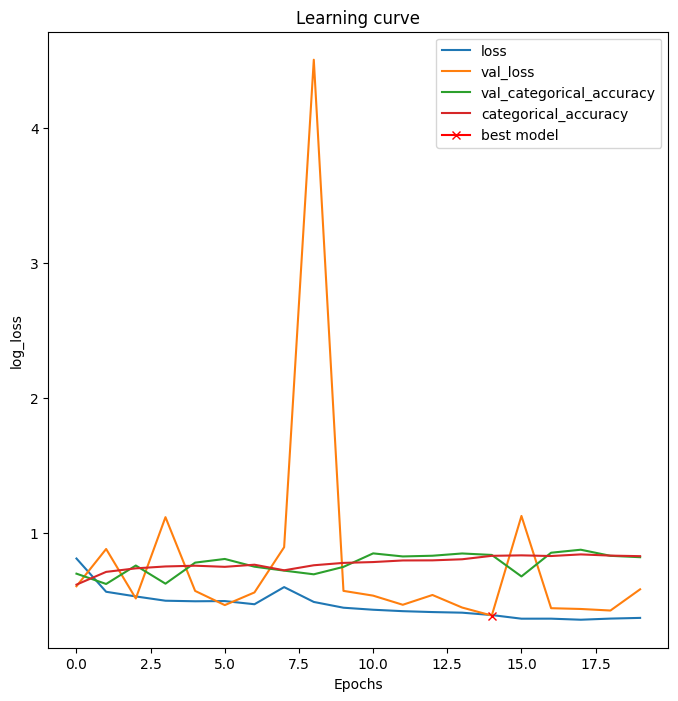

In [ ]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot(results.history["val_categorical_accuracy"], label="val_categorical_accuracy")
plt.plot(results.history["categorical_accuracy"], label="categorical_accuracy")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

Evaluate the trained weights and predict

In [16]:
# Load best model
#Have a llook at all saved models and take the one with the highest epoch value
model.load_weights("/content/drive/MyDrive/Data/best_model.h5")

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
# Evaluate on test set
eval = model.evaluate(x_test, y_test)
print('Test loss:', eval[0])
print('Test accuracy:', eval[1])

1/1 [==============================] - 27s 27s/step - loss: 0.9593 - categorical_accuracy: 0.3827 - f1: 0.5087
Test loss: 0.9593076705932617
Test accuracy: 0.3827247619628906


In [19]:
# Predict on train, val and test
preds_train = model.predict(x_train[0:10], verbose=1)
preds_val = model.predict(x_val, verbose=1)
preds_test = model.predict(x_test, verbose=1)

1/1 [==============================] - 23s 23s/step


In [20]:
# Threshold prediction probabilities
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

Plot Results

In [21]:
def plot_sample_all(X, y, preds, binary_preds, ix=None, filename='Sample.png'):
    import matplotlib

    matplotlib.rc('xtick', labelsize=20)
    matplotlib.rc('ytick', labelsize=20)
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(3, 2, sharex=True, sharey=True, figsize=(20, 10))
    r_band = (X[ix,:,:,0]-np.min(X[ix,:,:,0]))/(np.max(X[ix,:,:,0])-np.min(X[ix,:,:,0]))
    g_band = (X[ix,:,:,1]-np.min(X[ix,:,:,1]))/(np.max(X[ix,:,:,1])-np.min(X[ix,:,:,1]))
    b_band = (X[ix,:,:,2]-np.min(X[ix,:,:,2]))/(np.max(X[ix,:,:,2])-np.min(X[ix,:,:,2]))
    RGB = np.stack((r_band, g_band, b_band), axis=-1)

    im0 = ax[0,0].imshow(RGB)
    #if has_mask:
        #ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])

    ax[0,0].set_title('Remote Sensing Image', fontsize=30)


    im1 = ax[0,1].imshow(X[ix,:,:,0].squeeze(), cmap='gray')

    ax[0,1].set_title('Green', fontsize=30)

    im2 = ax[1,0].imshow(X[ix,:,:,2].squeeze(), cmap='gray')

    ax[1,0].set_title('NIR', fontsize=30)

    total_mask = np.zeros((512, 512, 3))
    for i in range(512):
        for j in range(512):
            # Ocean
            if(y[ix,i,j,0]==1):
                total_mask[i,j,0]=1
                total_mask[i,j,1]=1
                total_mask[i,j,2]=1
            # Ice
            elif(y[ix,i,j,1]==1):
                total_mask[i,j,0]=0
                total_mask[i,j,1]=0
                total_mask[i,j,2]=1



    im3 = ax[1,1].imshow(total_mask)
    ax[1,1].set_title('Image Mask', fontsize=30)

    im4 = ax[2,0].imshow(binary_preds[ix,:,:,0].squeeze(), vmin=0, vmax=1)

    ax[2,0].set_title('Ocean (Binary)', fontsize=30)

    im5 = ax[2,1].imshow(binary_preds[ix,:,:,1].squeeze(), vmin=0, vmax=1)

    ax[2,1].set_title('Ice (Binary)', fontsize=30)

    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    plt.tick_params(axis='both', which='major', labelsize=22)
    fig.tight_layout();
    plt.savefig(filename)

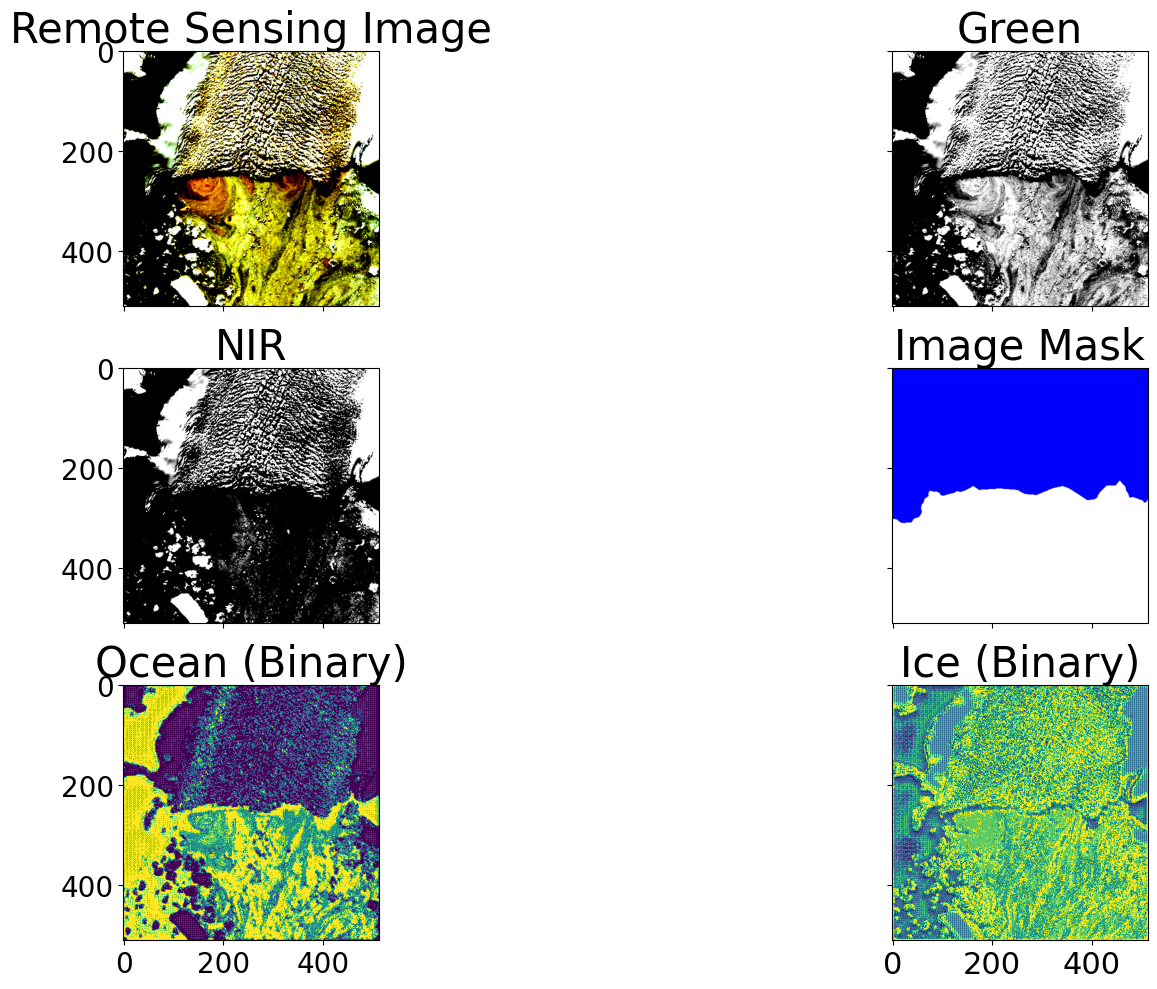

In [22]:
# Let's see how a prediction on the training data looks like
plot_sample_all(x_train, y_train, preds_train, preds_train_t, ix=9, filename='test.png')

This looks really good. What's about our test data?

In [23]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(20, 10))
    band = (X[ix,:,:,0]-np.min(X[ix,:,:,0]))/(np.max(X[ix,:,:,0])-np.min(X[ix,:,:,0]))
    #print(np.shape(RGB))
    im0 = ax[0,0].imshow(band.squeeze(), cmap='gray')
    #if has_mask:
        #ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    fig.colorbar(im0, ax=ax[0,0], fraction=0.046, pad=0.04)
    ax[0,0].set_title('Remote Sensing Image')

    im1 = ax[0,1].imshow(y[ix,:,:,1].squeeze(), vmin=0, vmax=1)
    ax[0,1].set_title('Lable Glacier')
    fig.colorbar(im1, ax=ax[0,1],fraction=0.046, pad=0.04)

    im2 = ax[1,0].imshow(preds[ix,:,:,1].squeeze(), vmin=0, vmax=1)
    #if has_mask:
        #ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    fig.colorbar(im2, ax=ax[1,0], fraction=0.046, pad=0.04)
    ax[1,0].set_title('Ice Predicted')

    im3 = ax[1,1].imshow(binary_preds[ix,:,:,1].squeeze(), vmin=0, vmax=1)
    #if has_mask:
        #ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    fig.colorbar(im3, ax=ax[1,1], fraction=0.046, pad=0.04)
    ax[1,1].set_title('Ice Predicted (Binary)')
    fig.tight_layout();

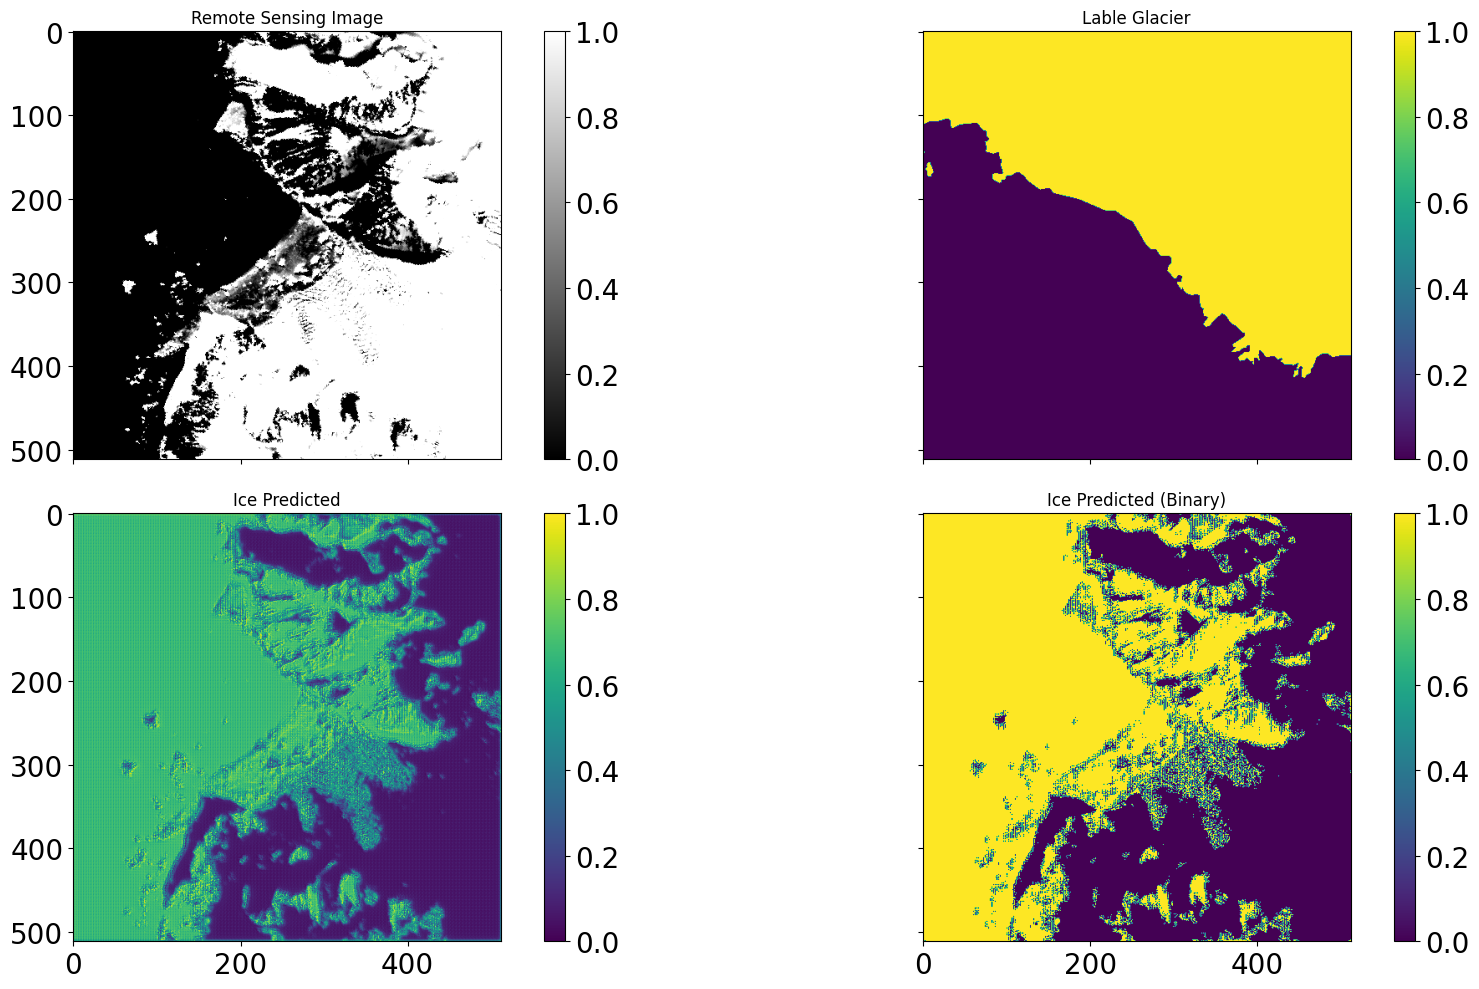

In [24]:
# Check if test data looks all right
plot_sample(x_test, y_test, preds_test, preds_test_t, ix=1)

Accuracy Metrics

In [25]:
x_total = np.concatenate((x_train, x_val, x_test), axis=0)
y_total = np.concatenate((y_train, y_val, y_test), axis=0)
pred_total = np.concatenate((preds_train_t, preds_val_t, preds_test_t), axis=0)

In [26]:
def print_roc_metrics(y_real, y_predict):

    c_matrix = confusion_matrix(y_real.ravel(), y_predict.ravel())
    f1 = f1_score(y_real.ravel(), y_predict.ravel())
    recall = recall_score(y_real.ravel(), y_predict.ravel())
    precision = precision_score(y_real.ravel(), y_predict.ravel())
    print("Confusion matrix:")
    print(c_matrix)
    print("F1 score: {:.4f}".format(f1))
    print("Recall score: {:.4f}".format(recall))
    print("Precision score: {:.4f}".format(precision))

In [27]:
print_roc_metrics(y_val, preds_val_t)

Confusion matrix:
[[ 927853  645011]
 [ 485350 1087514]]
F1 score: 0.6580
Recall score: 0.6914
Precision score: 0.6277
